# Task:

#### Based on the available data, it is necessary to build a predictive model that will predict the total profit for 30 days starting from the current date. Models need to be built for all data (all countries) and separately for the top 10 countries by income.

In [2]:
import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sys
import os
from datetime import datetime, timedelta
import re
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
import dill

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
# !git clone https://github.com/aavail/ai-workflow-capstone

All the necessary parameters are in the ./params_notebook.yaml

### Load parameters from yaml file

In [14]:
params = yaml.safe_load(open('./params_notebook.yaml'))

# path for original json train data
TRAIN_PATH = params['path']['train']
# path for original json test data
TEST_PATH = params['path']['test']
# path for saved models
MODEL_PATH = params['path']['models']

# list of top-10 countries and "all" countries
COUNTRIES = params['countries']

# number of splits for training models
splits_count = params['data_params']['splits_count']

params['models'] contains imports libraries and model parameters for grid search, for example:

In [6]:
params['models']['Lasso(random_state=42)']['params']

{'model__alpha': [0.001, 0.01, 0.1, 0, 1],
 'model__selection': ['cyclic', 'random']}

import the necessary libraries for our models. These models will be trained and the model with the smallest error on the test will be set as the test model.

In [13]:
for model in params['models']:
    statement = params['models'][model]['import']
    print(statement)
    exec(statement)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor


### Collect all json files in one pandas.DataFrame

In [15]:
# Function that collect all json files in one pandas.DataFrame
# input - path with json files
# output - pandas.DataFrame

def collect_data(path):
    
    # If path not exist rise exception
    if not os.path.isdir(path):
        raise(Exception('Directory does not exist'))
    
    # Columns of output df
    columns = ['country', 'customer_id', 'invoice', 'price', 'stream_id', 'times_viewed', 'year', 'month', 'day']
    # List of json files
    json_list = [i for i in os.listdir(path) if re.fullmatch(r'.+\.json$', i)]

    data = pd.DataFrame(columns=columns)
    
    # If no json files in path, rise exception
    if len(json_list) < 1:
        raise(Exception('No file to load'))
       
    # Add json files in df
    for file_name in json_list:
        df = pd.read_json(os.path.join(path, file_name))
        df.columns = columns
        data = data.append(df)
    
    # Create column date from columns "year", "month" and "day"
    data['date'] = pd.to_datetime(data.year.astype('str')+'-'+data.month.astype('str')+'-'+data.day.astype('str'))
    data['country'] = data.country.str.lower()
           
    return data.sort_values(by='date').reset_index(drop=True)

data = collect_data(TRAIN_PATH)
data.head()

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,date
0,united kingdom,16620.0,489598,2.10,22280,6,2017,11,28,2017-11-28
1,united kingdom,13085.0,489434,6.75,79323P,12,2017,11,28,2017-11-28
2,united kingdom,13085.0,489434,6.75,79323W,12,2017,11,28,2017-11-28
3,united kingdom,13085.0,489434,2.10,22041,21,2017,11,28,2017-11-28
4,united kingdom,13085.0,489434,1.25,21232,5,2017,11,28,2017-11-28


### Transform original DataFrame in new DataFrame to country

#### Columns of new DataFrame:
 - unique_invoice - number of unique invoice in this date
 - total_views - total number of views in this date
 - revenue - sum of all sales in this date
 - purchases - number of purchases in this day
 - total_streams - total number of unique streams in this date

In [16]:
# Function that transform original data to new df
# input: 
# original_data - original df
# country - country
# output - new pandas.DataFrame

def transform_data(original_data, country):
    
    df = original_data.copy()
    
    # Create list of all dates from min date to max date
    start_date = df.date.min()
    end_date = df.date.max()
    dates_range = pd.date_range(start_date, end_date)
    
    # Select from original df only rows with input country
    if country!='all':
        if country not in df.country.unique():
            raise Exception('Country not found')
        df = df[df.country==country]
    
    # bring the invoice to one format
    df['invoice'] = df.invoice.str.extract(r'([0-9]+)')
    
    # create new df 
    df_to_join = pd.DataFrame({'date': dates_range})  
    
    df = df.groupby('date').agg({'country': len,
                                 'invoice': lambda x: len(np.unique(x)),
                                 'stream_id': lambda x: len(np.unique(x)),
                                 'times_viewed': np.sum,
                                 'price': np.sum}).reset_index()
    
    df.rename(columns={'invoice': 'unique_invoices',
                       'times_viewed': 'total_views',
                       'price': 'revenue',
                       'country': 'purchases',
                       'stream_id': 'total_streams'}, inplace=True)
  
    
    
    df = pd.merge(df_to_join, df, how='left', on='date').fillna(0)
           
    return df

data_transformed = transform_data(original_data=data, country='all')
data_transformed.head()

,date,purchases,unique_invoices,total_streams,total_views,revenue
0,2017-11-28,3223.0,166.0,1345.0,15047.0,14450.54
1,2017-11-29,3277.0,133.0,1397.0,14159.0,13411.96
2,2017-11-30,3002.0,150.0,1335.0,15766.0,13290.25
3,2017-12-01,2559.0,107.0,1256.0,12524.0,9687.28
4,2017-12-02,402.0,32.0,287.0,3313.0,1443.26


### Visualize day's revenue for all countries

Text(0, 0.5, 'Revenue')

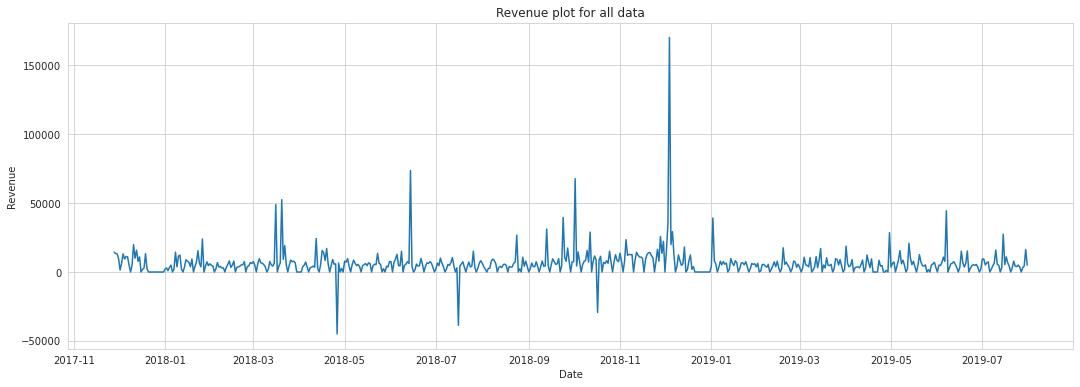

In [17]:
plt.figure(figsize=(18, 6))
plt.plot(data_transformed.date, data_transformed.revenue)
plt.title('Revenue plot for all data')
plt.xlabel('Date')
plt.ylabel('Revenue')

### Save transformed data for all countries

In [18]:
# Function that get dictioinary {country: transformed_data}
# If renew_all_csv = True data collects, transforms and saves to csv file for each country
# If not country function return dictionary with all 11 countries
def get_data(path, country=None, renew_all_csv=False):
    
    data_csv_path = os.path.join(path, 'convert_data')
    
    if not os.path.isdir(data_csv_path):
        os.mkdir(data_csv_path)
    
    # Determine for which countries need to save the csv file.
    # For those countries that do not have a csv file or for all if renew_all=True
    countries_to_csv = set(COUNTRIES) if renew_all_csv \
                    else set(COUNTRIES).difference([i.split('.')[0] for i in os.listdir(data_csv_path)]) 
    
    # For countries_to_csv load, transform and save data
    if len(countries_to_csv) > 0:
        print(f'...Collect json files from {path}')
        df = collect_data(path)
        print(f'...Create csv files')
        for c in countries_to_csv:
            data_country = transform_data(original_data=df, country=c)
            data_country.to_csv(os.path.join(data_csv_path, c)+'.csv', index=False)
            print(f'......csv file for {c} created successfuly')
        print(f'...all csv files from {path} created successfuly\n')
    
    # If there is already a csv file for the country, then it will simply load
    if country:
        return {country: pd.read_csv(os.path.join(data_csv_path, country.lower())+'.csv', parse_dates=['date'])}
        
    return {i.split('.')[0]: pd.read_csv(os.path.join(data_csv_path, i), parse_dates=[date]) for i in os.listdir(data_csv_path)}

### Exponential Smoothing

The graph above shows that there are revenue values similar to outliers. Let's try to smooth the data for training and look at the result for each country with a smoothing coefficient alpha=0.5

In [19]:
def get_crit_max(data, num_interquarter_ranges=4):
    
    data_non_zero = data
    interquart_range = np.percentile(data_non_zero, 75) - np.percentile(data_non_zero, 25)
    crit_max = data_non_zero.mean() + num_interquarter_ranges * interquart_range
    return crit_max

In [20]:
def exponential_smoothing(serie, alpha=0.9):
    
    serie = serie.copy()
    crit_max = get_crit_max(serie, num_interquarter_ranges=4)

    serie_hat = [serie.iloc[0]]
    for i in range(1, len(serie)):
        serie_hat.append(alpha*serie_hat[i-1] + (1-alpha)*serie.iloc[i])
    
    indices = (serie <= 0) | (serie > crit_max)
    
    serie.loc[indices] = np.array(serie_hat)[indices]
    
    
    return serie

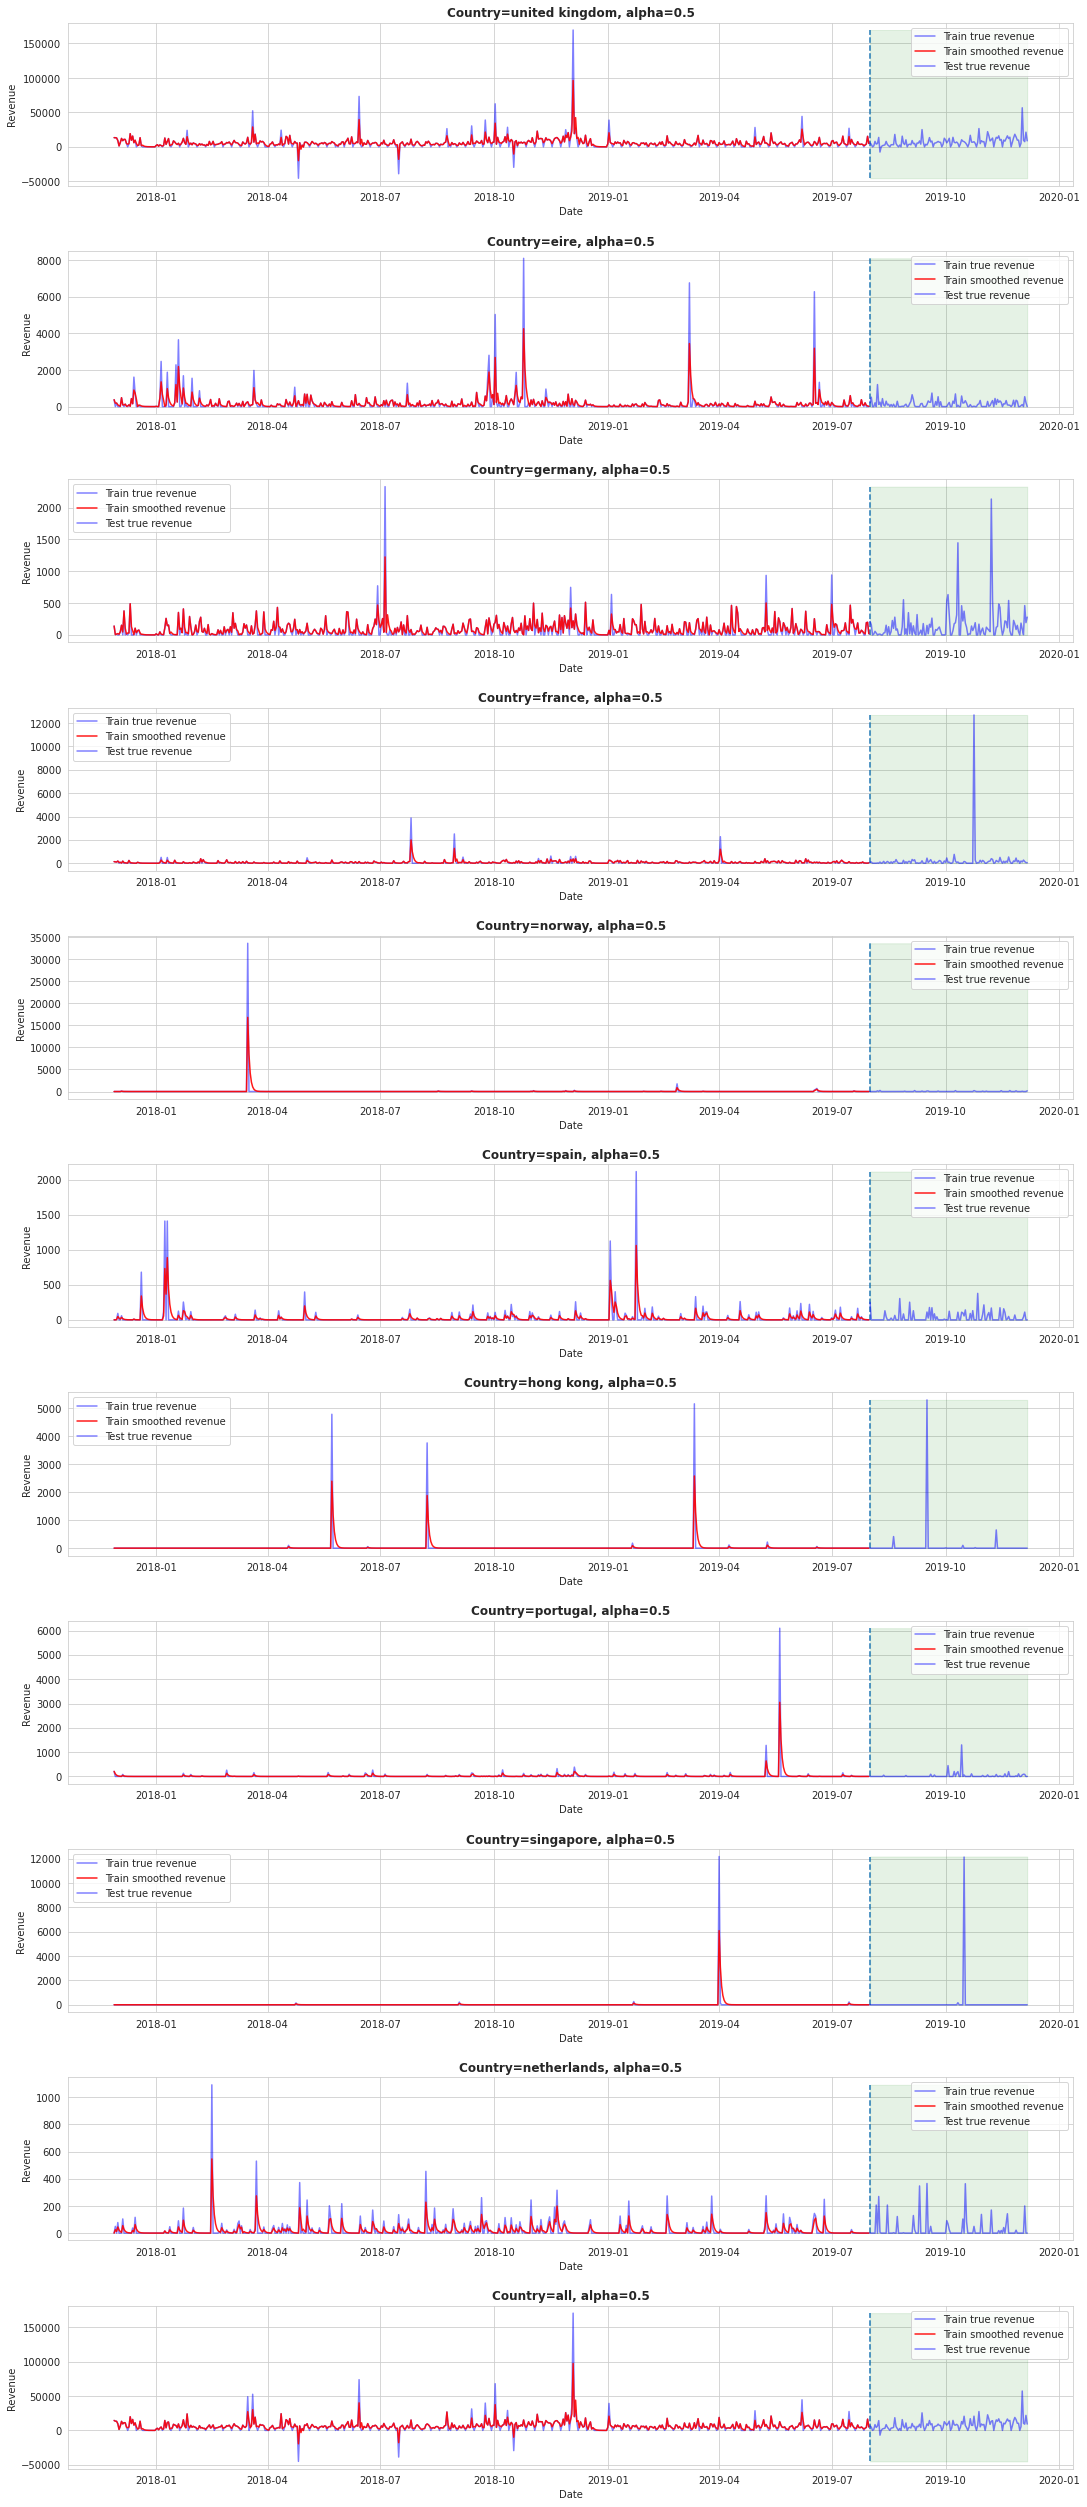

In [22]:
alpha = 0.5

fig, ax = plt.subplots(nrows=11, ncols=1, figsize=(18, 45))
ax = ax.flatten()

for idx, country in enumerate(COUNTRIES):
    train_data = get_data(TRAIN_PATH, country)[country][['date', 'revenue']]
    train_data['smoothed_revenue'] = exponential_smoothing(train_data.revenue, alpha=alpha)
    train_data.set_index('date', inplace=True, drop=True)
    test_data = get_data(TEST_PATH, country)[country][['date', 'revenue']]
    test_data.set_index('date', inplace=True, drop=True)
    
    
    ax[idx].plot(train_data.revenue, label='Train true revenue', color='blue', alpha=0.5)
    ax[idx].plot(train_data.smoothed_revenue, label='Train smoothed revenue', color='red', alpha=0.9)
    ax[idx].plot(test_data.revenue, label='Test true revenue', color='blue', alpha=0.5)
    
    ax[idx].vlines(x=test_data.index.min(), 
               ymin=min(train_data.revenue.min(), test_data.revenue.min()), 
               ymax=max(train_data.revenue.max(), test_data.revenue.max()), 
               linestyles='dashed')
    
    ax[idx].fill_betweenx(y=np.linspace(min(train_data.revenue.min(), test_data.revenue.min()), 
                                    max(train_data.revenue.max(), test_data.revenue.max()), 1000), 
                      x1=test_data.index.min(), 
                      x2=test_data.index.max(), 
                      alpha=0.1, 
                      color='green')
    ax[idx].set_title(f'Country={country}, alpha={alpha}', fontweight='bold')
    ax[idx].set_xlabel('Date')
    ax[idx].set_ylabel('Revenue')
    ax[idx].legend()

plt.subplots_adjust(hspace=0.4)

In [23]:
# Function that return X_train, X_test, y_train, y_test for input country
# X_train, X_test - pandas.DataFrames with columns:
# 'revenue' - revenue in this day
# 'sum_2_to_29' - sum of revenues for next 28 days relative to the current date
# 'y' - target variable (y_train, y_test). Will not be used in training

def get_train_test_data(country, alpha=0., renew_data=False):
    
    # Get transformed data for train and test
    train_data = get_data(TRAIN_PATH, country, renew_data)[country][['date', 'revenue']]
    # Smooth train data
    train_data['revenue'] = exponential_smoothing(train_data.revenue, alpha=alpha)
    train_data.set_index('date', inplace=True, drop=True)
    test_data = get_data(TEST_PATH, country, renew_data)[country][['date', 'revenue']]
    test_data.set_index('date', inplace=True, drop=True)
    
    # Union of train and test data
    all_data = train_data.append(test_data)
    all_data['y'], all_data['sum_2_to_29'] = None, None
    
    # Compute output columns
    for date in all_data.index[:-29]:
        mask = np.in1d(all_data.index, pd.date_range(date, date+timedelta(30), closed='left'))
        all_data.loc[date, 'y'] = all_data[mask].revenue.sum()
        mask = np.in1d(all_data.index, pd.date_range(date+timedelta(1), date+timedelta(29), closed='left'))
        all_data.loc[date, 'sum_2_to_29'] = all_data[mask].revenue.sum()
    
    # Drop rows with missed values
    all_data.dropna(inplace=True)
    
    # Split data on train and test
    X_train = all_data[train_data.index.min():train_data.index.max()]
    y_train = all_data[train_data.index.min():train_data.index.max()].y
    X_test = all_data[test_data.index.min():]
    y_test = all_data[test_data.index.min():].y
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_data('all')
X_train.head()

,revenue,y,sum_2_to_29
date,,,
2017-11-28,14450.54,198307.76,183857.22
2017-11-29,13411.96,183857.22,170445.26
2017-11-30,13290.25,170445.26,157155.01
2017-12-01,9687.28,157155.01,147467.73
2017-12-02,1443.26,147467.73,146024.47


Сreate a FeatureCreator class that will create a new dataframe from the number of lags by the target variable and encoded variables by the target variable

In [24]:
class FeaturesCreator(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_lags=30, window_size=1):
        # Number lags
        self.num_lags = num_lags
        self.window_size = window_size

    
    def fit(self, X, y=None):
        self.X = X
        # Save train indices (dates) for differences between train and test data
        self.__train_indices = X.index.tolist()
        # Mean values for revenue by monthes
        self.__revenue_month_mean = dict(X.revenue.groupby(X.index.month).mean())
        # Mean values for revenue by days of week
        self.__revenue_day_of_week_mean = dict(X.revenue.groupby(X.index.day_of_week).mean())
        # Mean values for revenue by days
        self.__revenue_day_mean = dict(X.revenue.groupby(X.index.strftime('%m-%d')).mean())
        # Mean values for target values by days
        self.__y_day_mean = dict(X.y.groupby(X.index.strftime('%m-%d')).mean())       
        # Save last rows for X_test. Needed to crate lags on test df
        self.X_to_top_test = X[-self.num_lags:]
        self.start_date = X.index.max()
        return self
    
    def transform(self, X):
        X = X.copy()
        X = self._add_rows_to_df(X)
        X = self._add_features(X)
        X.dropna(inplace=True)
        return X

    def _add_first_rows_to_train(self, X):
        # for train df add rows by mean on day '%m-%d'
        for date in reversed(pd.date_range(X.index.min()-timedelta(self.num_lags), X.index.min(), closed='left')):
            revenue = self.__revenue_day_mean[date.strftime('%m-%d')]
            y = X[:29].revenue.sum() + revenue
            sum_2_to_29 = X[:28].revenue.sum()
            df_row = pd.DataFrame({'revenue': [revenue], 'y': [y], 'sum_2_to_29': [sum_2_to_29]}, index=[date])
            X = df_row.append(X)
        return X
    
    def _add_rows_to_df(self, X):
        # if indices of input df match with indices of input df that had fit
        if self.__train_indices == X.index.tolist():
            X = self._add_first_rows_to_train(X)
        else:
            X = self.X_to_top_test.append(X)
        return X
 
    # add encoded features by target values and revenues 
    def _add_features(self, X):
        X['monthes'] = X.index.map(
            lambda x: [date.month for date in pd.date_range(x, x+timedelta(30), closed='left')])
        
        X['mean_by_month'] = X.monthes.map(
            lambda x: np.mean([self.__revenue_month_mean[i] for i in x]))        
        
        X['monthes_window'] =  X.index.map(
            lambda x: [date.month for date in pd.date_range(x+timedelta(29-self.window_size), 
                                                            x+timedelta(29+self.window_size))])
        
        X['mean_month_window'] = X.monthes_window.map(
            lambda x: np.mean([self.__revenue_month_mean[i] for i in x]))
              
        for lag in range(1, self.num_lags+1):
            X[f'y_lag_{lag}'] = X.y.shift(lag)

        X.drop(['monthes', 'monthes_window', 'y'], axis=1, inplace=True)
        return X

In [25]:
# Function that fit model for country with smoothing

# inputs:
# country
# alpha - smoothing coefficient 
# creator - FeaturesCreator object
# model - model that will be fit

# outputs:
# fitted model, y_test values, predictions for X_test, rmse on test, baseline error on test

def train_model(country, alpha, creator, model):
    # get splited data
    X_train, X_test, y_train, y_test = get_train_test_data(country, alpha=alpha)
    
    # transform this data
    X_train = creator.fit_transform(X_train)
    X_test = creator.transform(X_test)
    
    # fit model
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # get errors
    rmse = mean_squared_error(y_test, preds)**0.5
    baseline_rmse = np.mean((y_test - y_train.mean())**2)**0.5
    
    return model, y_test, preds, rmse, baseline_rmse

### Train simple model with different alphas

Let's see if alpha affects the quality of the model. To do this, we will train the same model for different countries with different alphas from 0 to 0.9

#### All data

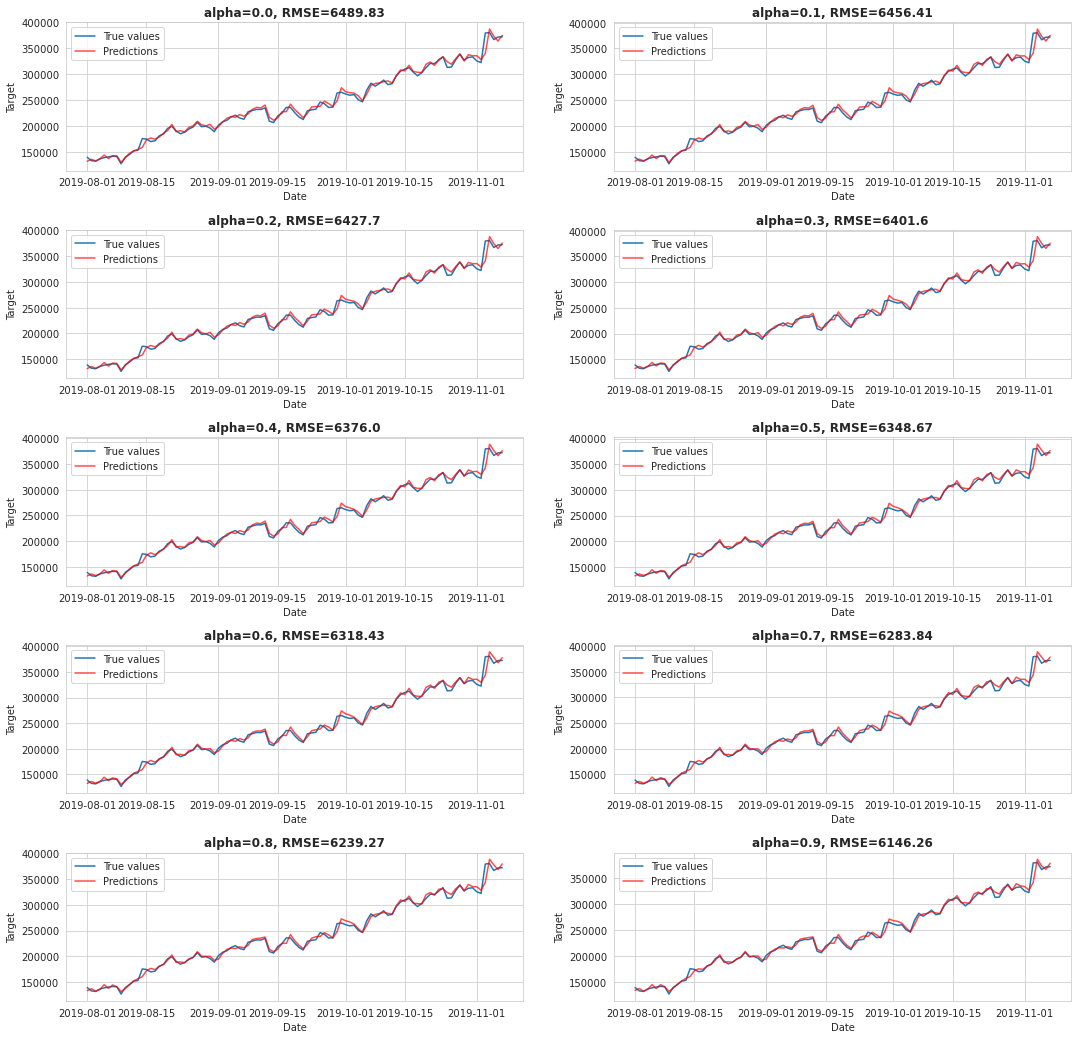

In [26]:
country = 'all'
window_size = 1
num_lags = 30

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(18, 18))
ax = ax.flatten()

for idx, smoothed_alpha in enumerate(np.arange(0, 1, 0.1)):
    
    creator = FeaturesCreator(num_lags=num_lags,
                              window_size=window_size)
    
    model = Lasso(random_state=42, alpha=1e-3, selection='cyclic')
    
    _, y_test, preds, rmse, _ = train_model(country=country,
                                            alpha=smoothed_alpha,
                                            creator=creator,
                                            model=model)

    ax[idx].plot(y_test, label='True values')
    ax[idx].plot(pd.Series(preds, index=y_test.index), label='Predictions', alpha=0.7, color='red')
    ax[idx].set_title(f'alpha={round(smoothed_alpha, 1)}, RMSE={round(rmse, 2)}', fontweight='bold')
    ax[idx].set_xlabel('Date')
    ax[idx].set_ylabel('Target')
    ax[idx].legend()
    
plt.subplots_adjust(hspace=0.4)

#### Netherlands

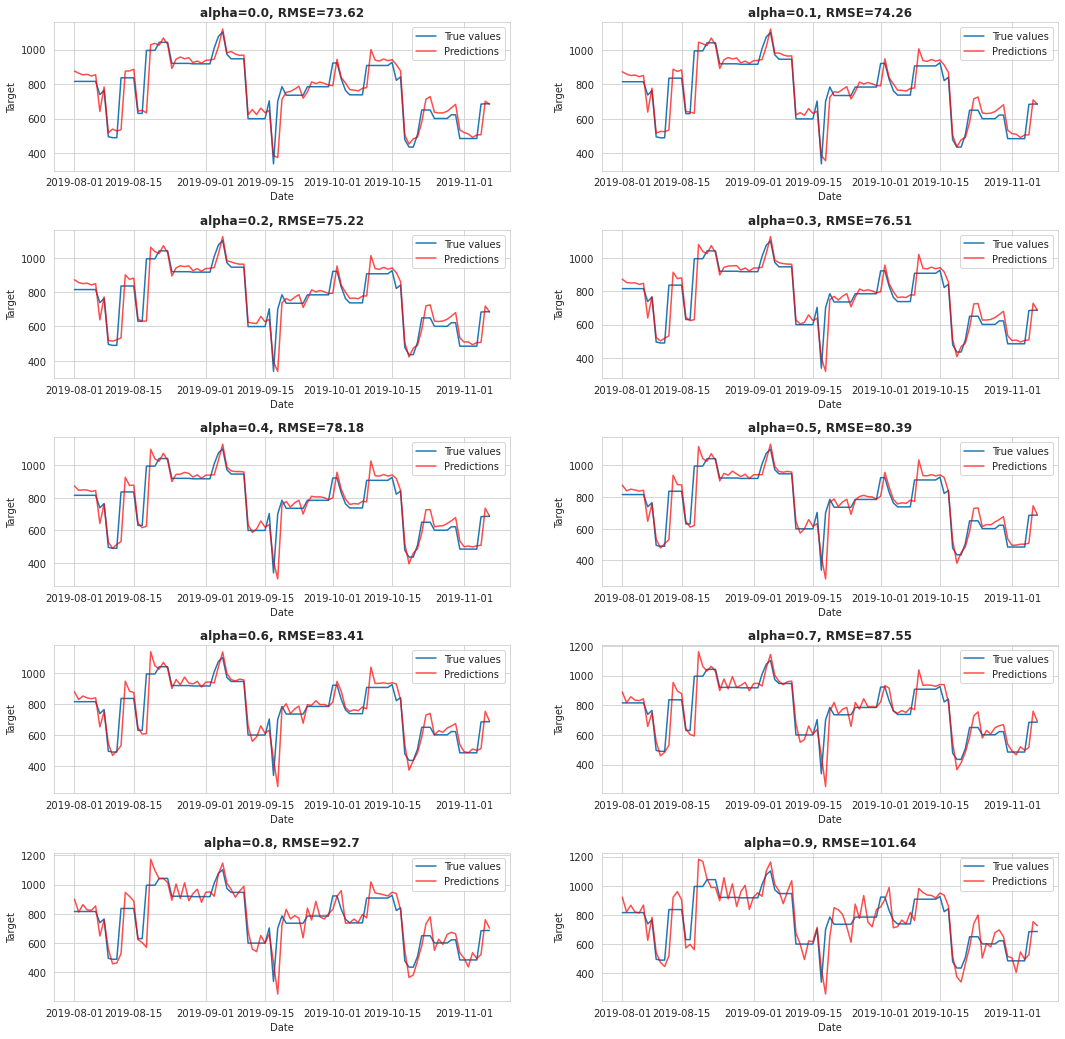

In [27]:
country = 'netherlands'
window_size = 1
num_lags = 30

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(18, 18))
ax = ax.flatten()

for idx, smoothed_alpha in enumerate(np.arange(0, 1, 0.1)):
    
    creator = FeaturesCreator(num_lags=num_lags,
                              window_size=window_size)
    
    model = Lasso(random_state=42, alpha=1e-3, selection='cyclic')
    
    _, y_test, preds, rmse, _ = train_model(country=country,
                                            alpha=smoothed_alpha,
                                            creator=creator,
                                            model=model)

    ax[idx].plot(y_test, label='True values')
    ax[idx].plot(pd.Series(preds, index=y_test.index), label='Predictions', alpha=0.7, color='red')
    ax[idx].set_title(f'alpha={round(smoothed_alpha, 1)}, RMSE={round(rmse, 2)}', fontweight='bold')
    ax[idx].set_xlabel('Date')
    ax[idx].set_ylabel('Target')
    ax[idx].legend()
    
plt.subplots_adjust(hspace=0.4)

#### France

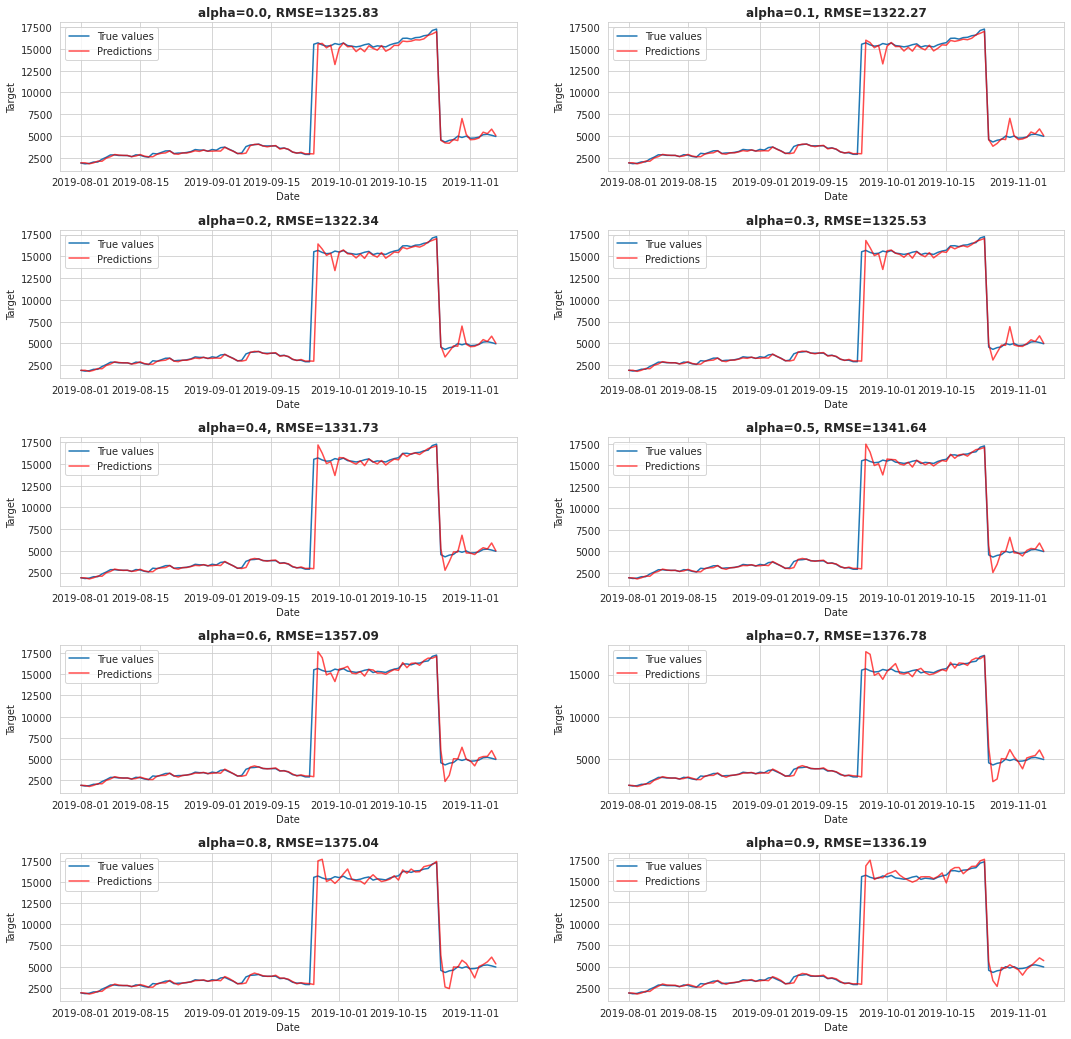

In [28]:
country = 'france'
window_size = 1
num_lags = 30

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(18, 18))
ax = ax.flatten()

for idx, smoothed_alpha in enumerate(np.arange(0, 1, 0.1)):
    
    creator = FeaturesCreator(num_lags=num_lags,
                              window_size=window_size)
    
    model = Lasso(random_state=42, alpha=1e-3, selection='cyclic')
    
    _, y_test, preds, rmse, _ = train_model(country=country,
                                            alpha=smoothed_alpha,
                                            creator=creator,
                                            model=model)

    ax[idx].plot(y_test, label='True values')
    ax[idx].plot(pd.Series(preds, index=y_test.index), label='Predictions', alpha=0.7, color='red')
    ax[idx].set_title(f'alpha={round(smoothed_alpha, 1)}, RMSE={round(rmse, 2)}', fontweight='bold')
    ax[idx].set_xlabel('Date')
    ax[idx].set_ylabel('Target')
    ax[idx].legend()
    
plt.subplots_adjust(hspace=0.4)

We see that exponential smoothing does not provide significant improvements to the models. And for some countries, the quality of the models deteriorates with an increase in alpha.

Therefore, we will train a simple model for each country with alpha = 0 and look at the results

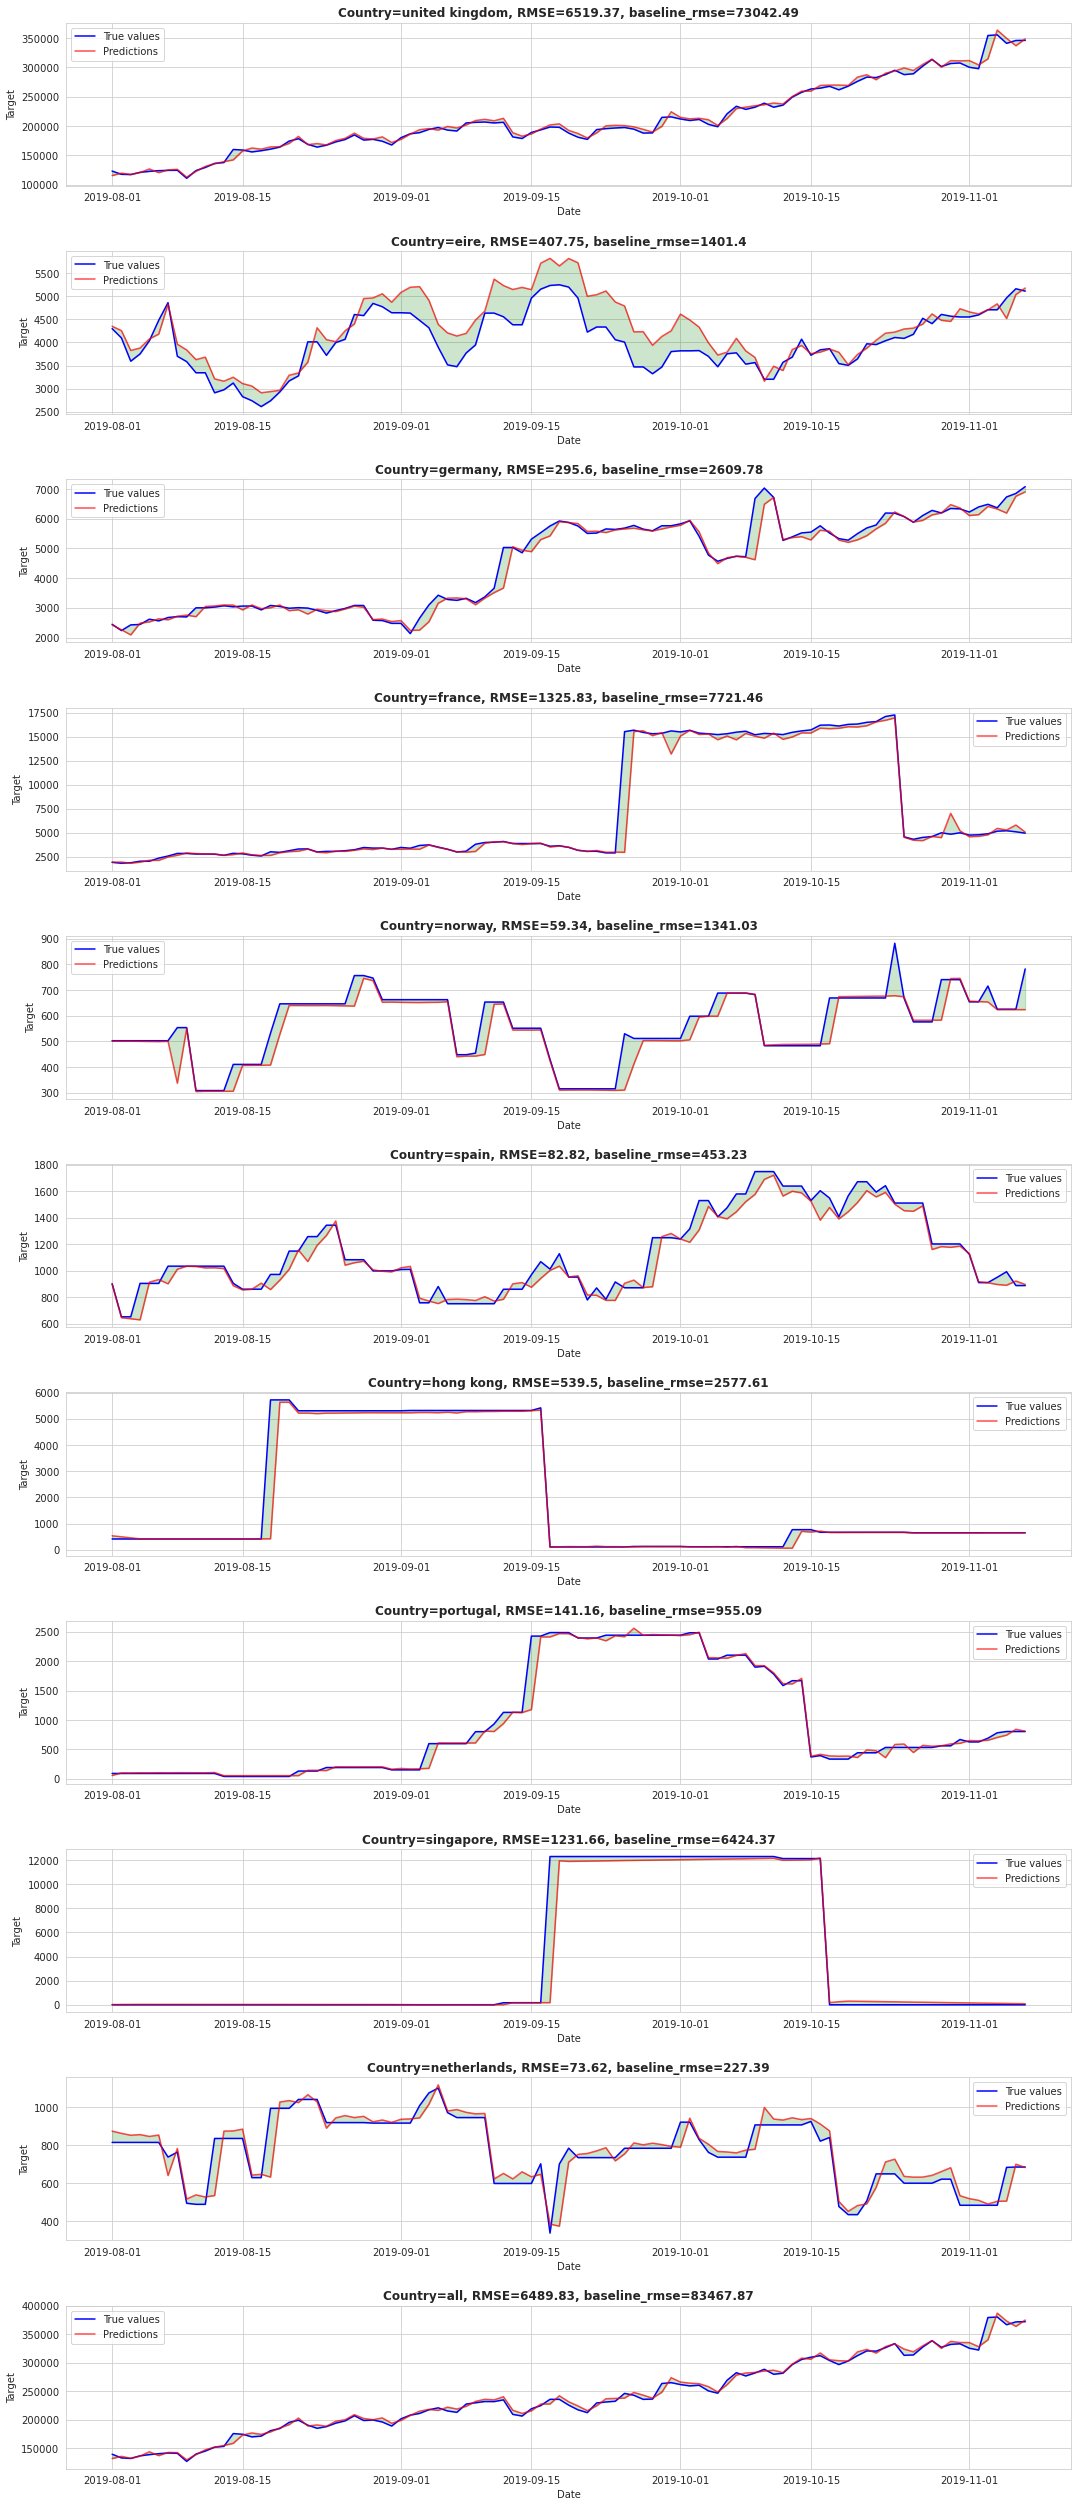

In [29]:
smoothed_alpha = 0.
window_size = 1
num_lags = 30

fig, ax = plt.subplots(nrows=11, ncols=1, figsize=(18, 45))
ax = ax.flatten()

for idx, country in enumerate(COUNTRIES):

    creator = FeaturesCreator(num_lags=num_lags,
                              window_size=window_size)

    
    model = Lasso(random_state=42, alpha=1e-3, selection='cyclic')
    
    _, y_test, preds, rmse, baseline_rmse = train_model(country=country,
                                            alpha=smoothed_alpha,
                                            creator=creator,
                                            model=model)    

    ax[idx].plot(y_test, label='True values', color='blue')
    ax[idx].plot(pd.Series(preds, index=y_test.index), label='Predictions', color='red', alpha=0.7)
    ax[idx].set_title(f'Country={country}, RMSE={round(rmse,2)}, baseline_rmse={round(baseline_rmse,2)}',
                                                                         fontweight='bold')
    ax[idx].set_xlabel('Date')
    ax[idx].set_ylabel('Target')
    ax[idx].fill_between(x=pd.date_range(y_test.index[0], y_test.index[-1]),
                         y1=np.array(preds),
                         y2=np.array(y_test.values, dtype=np.float64),
                         color='green',
                         alpha=0.2)
    ax[idx].legend()
    
plt.subplots_adjust(hspace=0.4)

Let's change our get_train_test_data function and FeaturesCreator a bit

In get_train_test_data function add one column to X_train and X_test. This column named last_revenue - revenue in the 30th day. This feature will help with further calculations and will not be involved in training. Also look at the resulting dataframes

In [30]:
def get_train_test_data(country, alpha=0., renew_data=False):
    
    train_data = get_data(TRAIN_PATH, country, renew_data)[country][['date', 'revenue']]
    train_data['revenue'] = exponential_smoothing(train_data.revenue, alpha=alpha)
    train_data.set_index('date', inplace=True, drop=True)
    test_data = get_data(TEST_PATH, country, renew_data)[country][['date', 'revenue']]
    test_data.set_index('date', inplace=True, drop=True)
    
    all_data = train_data.append(test_data)
    all_data['y'], all_data['sum_2_to_29'] = None, None
    
    for date in all_data.index[:-29]:
        mask = np.in1d(all_data.index, pd.date_range(date, date+timedelta(30), closed='left'))
        all_data.loc[date, 'y'] = all_data[mask].revenue.sum()
        mask = np.in1d(all_data.index, pd.date_range(date+timedelta(1), date+timedelta(29), closed='left'))
        all_data.loc[date, 'sum_2_to_29'] = all_data[mask].revenue.sum()
    
    all_data.dropna(inplace=True)
    all_data['last_revenue'] = all_data.y - all_data.revenue - all_data.sum_2_to_29
    
    
    X_train = all_data[train_data.index.min():train_data.index.max()]
    y_train = all_data[train_data.index.min():train_data.index.max()].y
    X_test = all_data[test_data.index.min():]
    y_test = all_data[test_data.index.min():].y
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_data('all')
X_train.head()

,revenue,y,sum_2_to_29,last_revenue
date,,,,
2017-11-28,14450.54,198307.76,183857.22,0.0
2017-11-29,13411.96,183857.22,170445.26,0.0
2017-11-30,13290.25,170445.26,157155.01,0.0
2017-12-01,9687.28,157155.01,147467.73,0.0
2017-12-02,1443.26,147467.73,146024.47,-0.0


FeaturesCreator, in addition to lags, will create variables that are the encoding of the target variable and the last_revenue feature

In [31]:
class FeaturesCreator(BaseEstimator, TransformerMixin):
    
    def __init__(self, 
                 num_lags=30,
                 window_size=1, 
                 num_quantiles=3, # number of quantiles previouse lags
                 target_season_features=['month', 'day_of_week'], # list values 'month', 'day', 'day_of_week'
                 type_of_target_season_features='mean', # 'mean', 'one-hot'
                 target_measure_features = ['min', 'max', 'median'], # 'min', 'max', 'median'
                 last_revenue_season_features = ['month', 'day_of_week'] # 'month', 'day', 'day_of_week'
                ):
        # number of target variable lags
        self.num_lags = num_lags
        self.window_size = window_size
        # number of quantiles by lags
        self.num_quantiles = num_quantiles
        # list of time units by which the target variable will be encoded
        self.target_season_features = target_season_features
        # type of encoding seasonal variables: one-hot or mean
        self.type_of_target_season_features = type_of_target_season_features
        # list of descriptive statistics by which the target variable will be coded
        self.target_measure_features = target_measure_features
        # list of time units by which the 30th day variable will be encoded
        self.last_revenue_season_features = last_revenue_season_features
        
        # Dictionary of functions to _add_target_measure_features
        self.target_measure_functions = dict({'median': np.median,
                                              'max': np.max,
                                              'min': np.min})
        
        self.__num_one_hot_features = dict({'day': 31, 'month': 12, 'day_of_week': 7})
        self.__quantiles = np.linspace(0, 1, num_quantiles+1, endpoint=False)[1:]
    
    def fit(self, X, y=None):
        # save X_train
        self.X = X
        # save X_train indices
        self.__train_indices = X.index.tolist()
        
        # Revenue mean values by monthes to 'mean_by_month' feature
        self.__revenue_month_mean = dict(X.last_revenue.groupby(X.index.month).mean())
        
        # Mean value of revenue by day for add first rows to train data
        self.__revenue_day_mean = dict(X.revenue.groupby(X.index.strftime('%m-%d')).mean())
        
        # Mean target values for season mean encode
        self.__target_season_mean_day = dict(X.y.groupby(X.index.day).mean())
        self.__target_season_mean_day_of_week = dict(X.y.groupby(X.index.day_of_week).mean())
        self.__target_season_mean_month = dict(X.y.groupby(X.index.month).mean())
        
        # functions for seasonal encoding target variable 
        self.__target_season_functions = dict({
            'day': [lambda x: self.__target_season_mean_day[x.day], lambda x: x.day-1],
            'day_of_week': [lambda x: self.__target_season_mean_day_of_week[x.day_of_week], lambda x: x.day_of_week],
            'month': [lambda x: self.__target_season_mean_month[x.month], lambda x: x.month-1]})
        
        # Mean last_revenue (30th day) for season mean encode
        self.__last_revenue_season_mean_day = dict(X.last_revenue.groupby(X.index.day).mean())
        self.__last_revenue_season_mean_day_of_week = dict(X.last_revenue.groupby(X.index.day_of_week).mean())
        self.__last_revenue_season_mean_month = dict(X.last_revenue.groupby(X.index.month).mean())
        # functions for seasonal encoding last revenue (30th day)
        self.__last_revenue_season_functions = dict({
            'day': lambda x: self.__last_revenue_season_mean_day[x.day],
            'day_of_week': lambda x: self.__last_revenue_season_mean_day_of_week[x.day_of_week],
            'month': lambda x: self.__last_revenue_season_mean_month[x.month]})
        # Save last rows for X_test. Needed to crate lags on test df       
        self.X_to_top_test = X[-self.num_lags:]
        self.start_date = X.index.max()
        return self
    
    
    def transform(self, X):
        X = X.copy()
        # add rows to df to create lags wihtout data loss
        X = self._add_rows_to_df(X)
        # add features to df
        X = self._add_features(X)
        X.dropna(inplace=True)
        X = self._add_target_season_features(X)
        X = self._add_target_measure_features(X)
        X = self._add_quantile_features(X)
        X = self._add_last_revenue_season_features(X)
        return X

    def _add_first_rows_to_train(self, X):
        # for train df add rows by mean on day '%m-%d'
        for date in reversed(pd.date_range(X.index.min()-timedelta(self.num_lags), X.index.min(), closed='left')):
            revenue = self.__revenue_day_mean[date.strftime('%m-%d')]
            y = X[:29].revenue.sum() + revenue
            sum_2_to_29 = X[:28].revenue.sum()
            df_row = pd.DataFrame({'revenue': [revenue], 'y': [y], 'sum_2_to_29': [sum_2_to_29]}, index=[date])
            X = df_row.append(X)
        return X
    
    def _add_rows_to_df(self, X):
        # if indices of input df match with indices of df that had fit
        if self.__train_indices == X.index.tolist():
            X = self._add_first_rows_to_train(X)
        else:
            X = self.X_to_top_test.append(X)
        return X
    
    
    def _add_target_season_features(self, X):
        X_output = X.copy()
        if self.target_season_features:
            if self.type_of_target_season_features == 'mean':
                for agg_func in self.target_season_features:
                    X_output[f'{agg_func}_mean_target'] = X_output.index.map(
                                                            self.__target_season_functions[agg_func][0])
            
            elif self.type_of_target_season_features == 'one-hot':
                for agg_func in self.target_season_features:
                    add = np.zeros((len(X), self.__num_one_hot_features[agg_func]))
                    add[range(len(X)), X.index.map(self.__target_season_functions[agg_func][1])] = 1
                    add = pd.DataFrame(add, index=X.index, 
                            columns=[f'{agg_func}_{i+1}' for i in range(self.__num_one_hot_features[agg_func])])
                    X_output = pd.concat([X_output, add], axis=1)
        return X_output
    
    def _add_target_measure_features(self, X):
        X_output = X.copy()
        
        if self.target_measure_features:
            for feature in self.target_measure_features:
                X_output[f'{feature}_lags'] = self.target_measure_functions[feature](
                                                X_output[[f'y_lag_{i}' for i in range(1, self.num_lags+1)]], axis=1)
        return X_output
    
    def _add_quantile_features(self, X):
        X_output = X.copy()
        if self.num_quantiles and self.num_quantiles>0:
            for idx, q in enumerate(self.__quantiles):
                if q==0.5 and 'median_lags' in X_output.columns:
                    continue
                X_output[f'q{idx+1}'] = np.quantile(X_output, q, axis=1)
        return X_output
    
    def _add_last_revenue_season_features(self, X):
        X_output = X.copy()
        if self.last_revenue_season_features:
            for agg_func in self.last_revenue_season_features:
                X_output[f'{agg_func}_mean_last_revenue'] = X_output.index.map(
                                                              self.__last_revenue_season_functions[agg_func])
        return X_output
        
    
    def _add_features(self, X):
        X['monthes'] = X.index.map(
            lambda x: [date.month for date in pd.date_range(x, x+timedelta(30), closed='left')])
        
        X['mean_by_month'] = X.monthes.map(
            lambda x: np.mean([self.__revenue_month_mean[i] for i in x]))        
        
        X['monthes_window'] =  X.index.map(
            lambda x: [date.month for date in pd.date_range(x+timedelta(29-self.window_size), 
                                                            x+timedelta(29+self.window_size))])
        
        X['mean_month_window'] = X.monthes_window.map(
            lambda x: np.mean([self.__revenue_month_mean[i] for i in x]))
              
        for lag in range(1, self.num_lags+1):
            X[f'y_lag_{lag}'] = X.y.shift(lag)

        X.drop(['monthes', 'monthes_window', 'y', 'last_revenue'], axis=1, inplace=True)
        return X

Let's look at the resulting dataframe

In [32]:
X_train, X_test, y_train, y_test = get_train_test_data('all')

creator = FeaturesCreator()
X_train_transformed = creator.fit_transform(X_train)
X_test_transformed = creator.transform(X_test)

X_test_transformed.head()

,revenue,sum_2_to_29,mean_by_month,mean_month_window,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,...,y_lag_30,month_mean_target,day_of_week_mean_target,min_lags,max_lags,median_lags,q1,q3,month_mean_last_revenue,day_of_week_mean_last_revenue
date,,,,,,,,,,,,,,,,,,,,,
2019-08-01,6477.52,121732.16,7327.611968,7327.611968,133174.61,146011.14,144272.75,131740.44,131740.44,132532.95,...,182877.601,172764.64571,192265.324931,122137.741,186939.361,145141.945,130727.2105,172769.782032,7327.611968,7.446389e+03
2019-08-02,4666.74,127897.26,7327.611968,7894.436756,139041.52,133174.61,146011.14,144272.75,131740.44,131740.44,...,179910.481,172764.64571,183956.245368,122137.741,186939.361,141706.9955,130727.2105,168177.867177,7327.611968,8.363170e-13
2019-08-03,0.00,127897.26,7384.294447,8461.261545,132564.0,139041.52,133174.61,146011.14,144272.75,131740.44,...,179419.631,172764.64571,179850.007529,122137.741,186939.361,139091.3805,130727.2105,164667.186,7327.611968,3.603814e+03
2019-08-04,1310.75,130274.96,7440.976925,9028.086333,131585.71,132564.0,139041.52,133174.61,146011.14,144272.75,...,172785.191,172764.64571,187497.251264,122137.741,186939.361,138950.285,130930.335,159870.711,7327.611968,7.663833e+03
2019-08-05,8444.06,126439.04,7497.659404,9028.086333,136193.85,131585.71,132564.0,139041.52,133174.61,146011.14,...,166648.941,172764.64571,194325.267023,122137.741,186939.361,138638.5505,130649.8455,158407.9835,7327.611968,1.047500e+04


Let's look at the results of training with the new FeaturesCreator

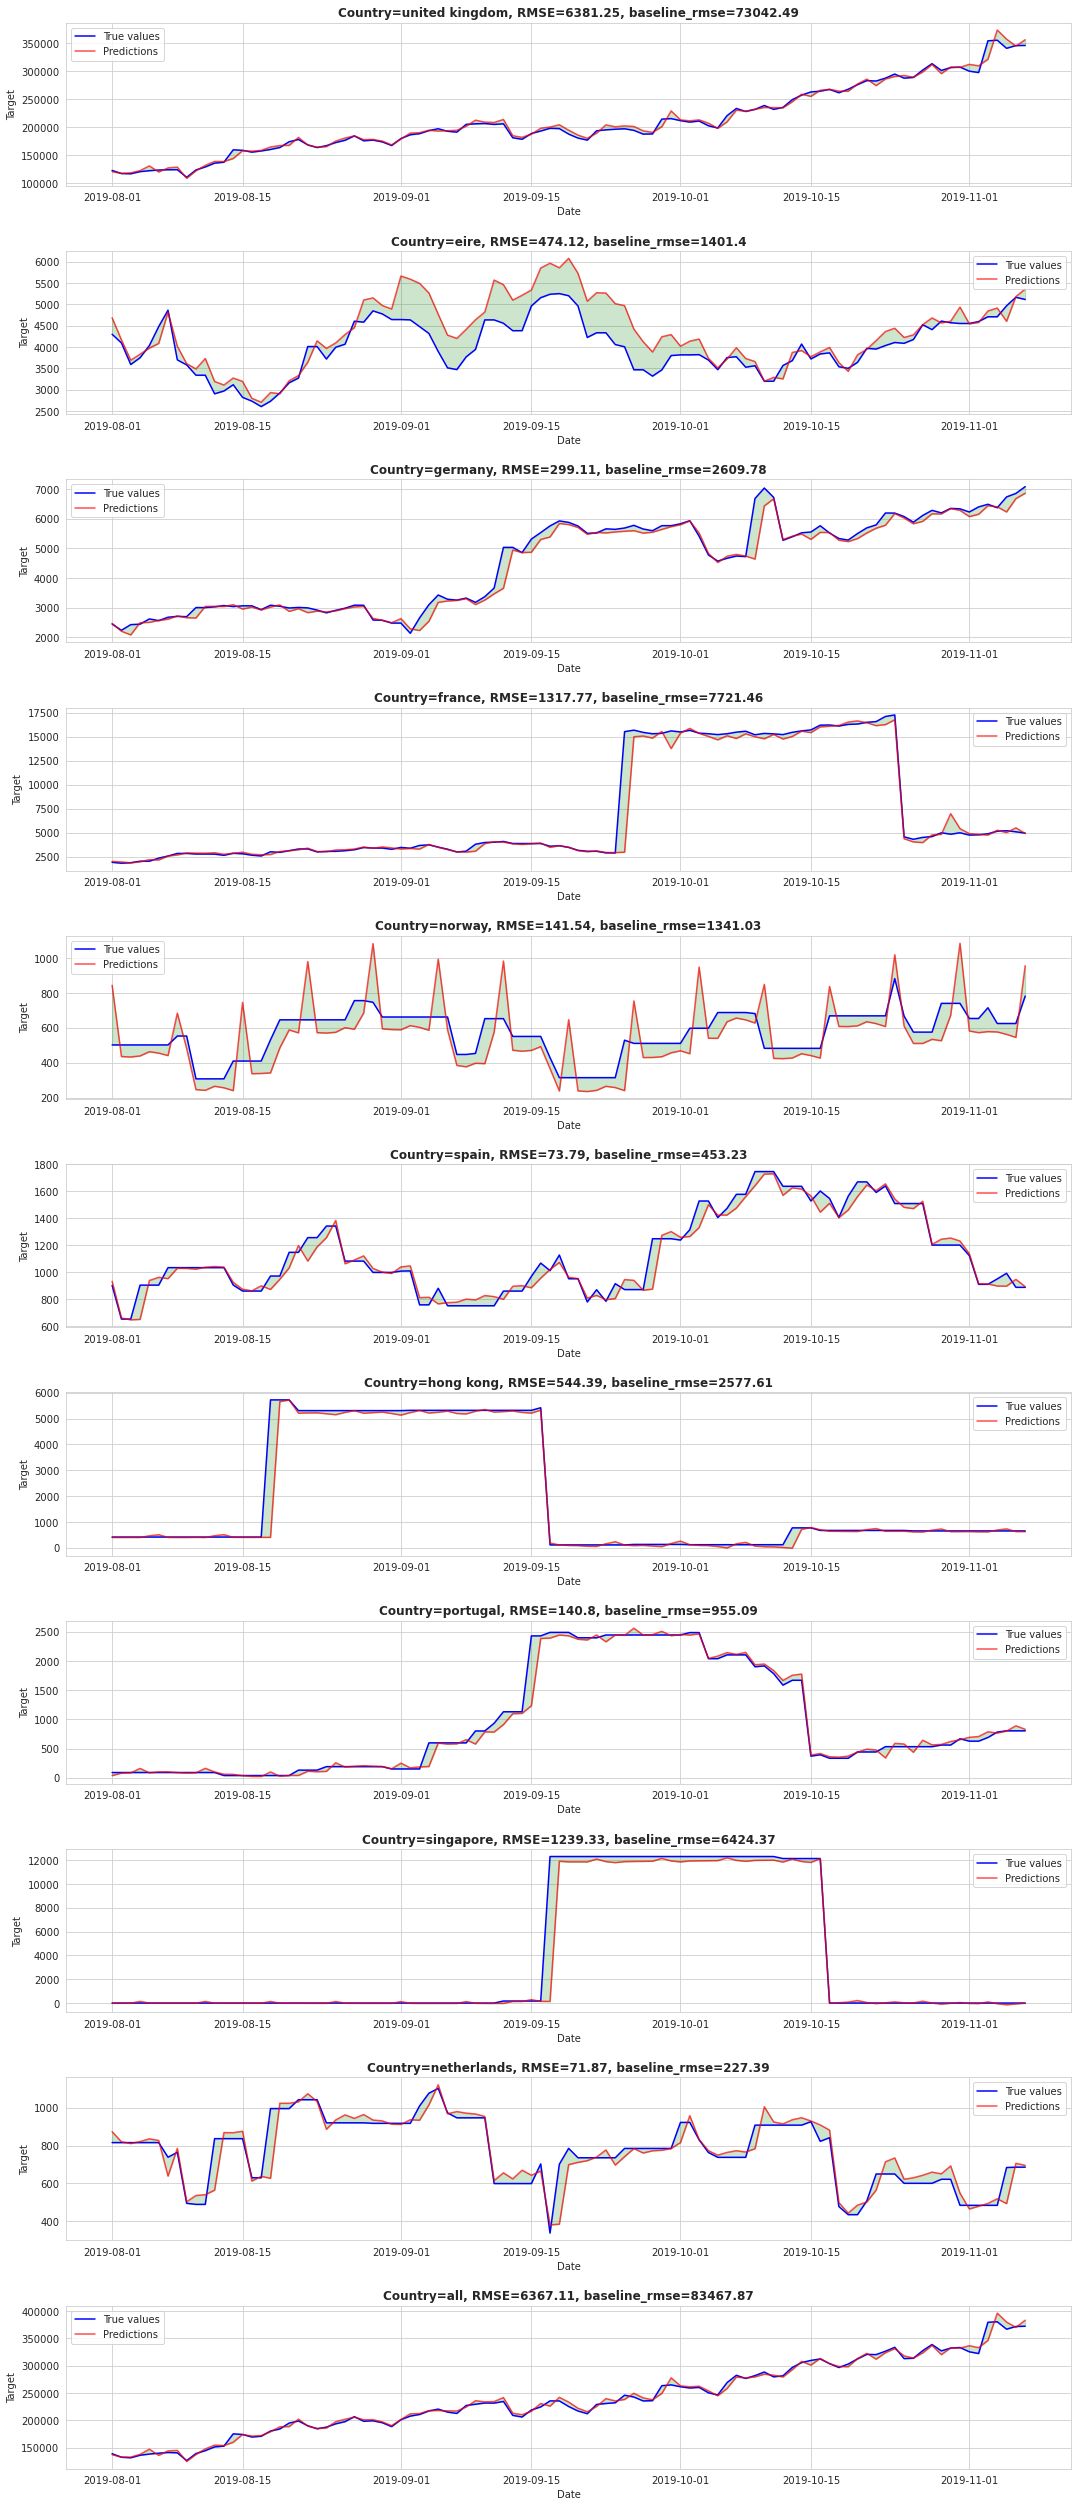

In [33]:
smoothed_alpha = 0.
country = 'all'
num_lags=30
window_size=1
num_quantiles=3
target_season_features=['month', 'day_of_week']
type_of_target_season_features='mean'
target_measure_features = ['min', 'max', 'median']
last_revenue_season_features = ['month', 'day_of_week']

fig, ax = plt.subplots(nrows=11, ncols=1, figsize=(18, 45))
ax = ax.flatten()

for idx, country in enumerate(COUNTRIES):

    creator = FeaturesCreator(num_lags, 
                              window_size,
                              num_quantiles,
                              target_season_features,
                              type_of_target_season_features,
                              target_measure_features,
                              last_revenue_season_features)

    
    model = Lasso(random_state=42, alpha=1e-3, selection='cyclic')
    
    _, y_test, preds, rmse, baseline_rmse = train_model(country=country,
                                            alpha=smoothed_alpha,
                                            creator=creator,
                                            model=model)    

    ax[idx].plot(y_test, label='True values', color='blue')
    ax[idx].plot(pd.Series(preds, index=y_test.index), label='Predictions', color='red', alpha=0.7)
    ax[idx].set_title(f'Country={country}, RMSE={round(rmse,2)}, baseline_rmse={round(baseline_rmse,2)}',
                                                                         fontweight='bold')
    ax[idx].set_xlabel('Date')
    ax[idx].set_ylabel('Target')
    ax[idx].fill_between(x=pd.date_range(y_test.index[0], y_test.index[-1]),
                         y1=np.array(preds),
                         y2=np.array(y_test.values, dtype=np.float64),
                         color='green',
                         alpha=0.2)
    ax[idx].legend()
    
plt.subplots_adjust(hspace=0.4)

It can be seen that for some countries the results have become worse. Perhaps it's all about a bad set of features. Therefore, we will look for the best model using GreadSearchCV. Thus, we will create our own dataframe for each country with its own set of features and find the best model for it. The quality of the model will be more stable, as it will be selected by cross-validation

The following function looks for the best parameters and models (in params.yaml) for each of the countries in cross-validation. But the search process takes a lot of time, so the models are already saved. If you want to search, uncomment lines. Let's load test (best models) models and look at the results on the test set

In [38]:
def fit_models_(country, renew_data, standard_parameters=False):
    
    X_train, X_test, y_train, y_test = get_train_test_data(country, renew_data)
    
    split_index = np.linspace(365, X_train.shape[0], splits_count+1).astype('int')
    cv = [[np.arange(split_index[i]), np.arange(split_index[i], split_index[i+1])]
              for i in range(len(split_index)-1)]
    
    
    for model_name in params['models']:
        print(f'......Train {model_name.split("(")[0]} model')
        creator = FeaturesCreator()
        model = eval(model_name)
       
        pipline =Pipeline(steps=[('creator', creator),
                                 ('model', model)])
        
        param_grid = params['models'][model_name]['params']
        param_grid.update(params['creator']) 
       
        gcv = GridSearchCV(estimator=pipline,
                           param_grid=param_grid,
                           cv=cv, 
                           scoring='neg_root_mean_squared_error')
        
        gcv.fit(X_train, y_train)
        best_estimator = gcv.best_estimator_
        test_preds = best_estimator.predict(X_test)
        rmse_error = mean_squared_error(y_test, test_preds)**0.5
        baseline_error = np.mean((y_test - y_train.mean())**2)**0.5
        
    return y_test, test_preds, rmse_error, baseline_error


# for idx, country in enumerate(COUNTRIES):
#     y_test, preds, rmse_error, baseline_error = fit_models_(country, renew_data=False)
#     
#     ax[idx].plot(y_test, label='True values', color='blue')
#     ax[idx].plot(pd.Series(preds, index=y_test.index), label='Predictions', color='red', alpha=0.7)
#     ax[idx].set_title(f'Country={country}, RMSE={round(rmse_error,2)}, baseline_error={round(baseline_error,2)}',
#                       fontweight='bold')
#     ax[idx].set_xlabel('Date')
#     ax[idx].set_ylabel('Target')
#     ax[idx].fill_between(x=pd.date_range(y_test.index[0], y_test.index[-1]),
#                          y1=np.array(preds),
#                          y2=np.array(y_test.values, dtype=np.float64),
#                          color='green',
#                          alpha=0.2)
#     ax[idx].legend()
#         
# plt.subplots_adjust(hspace=0.4)

Plot predictions on test sample. Results are saved for convenience. So let's just download them.

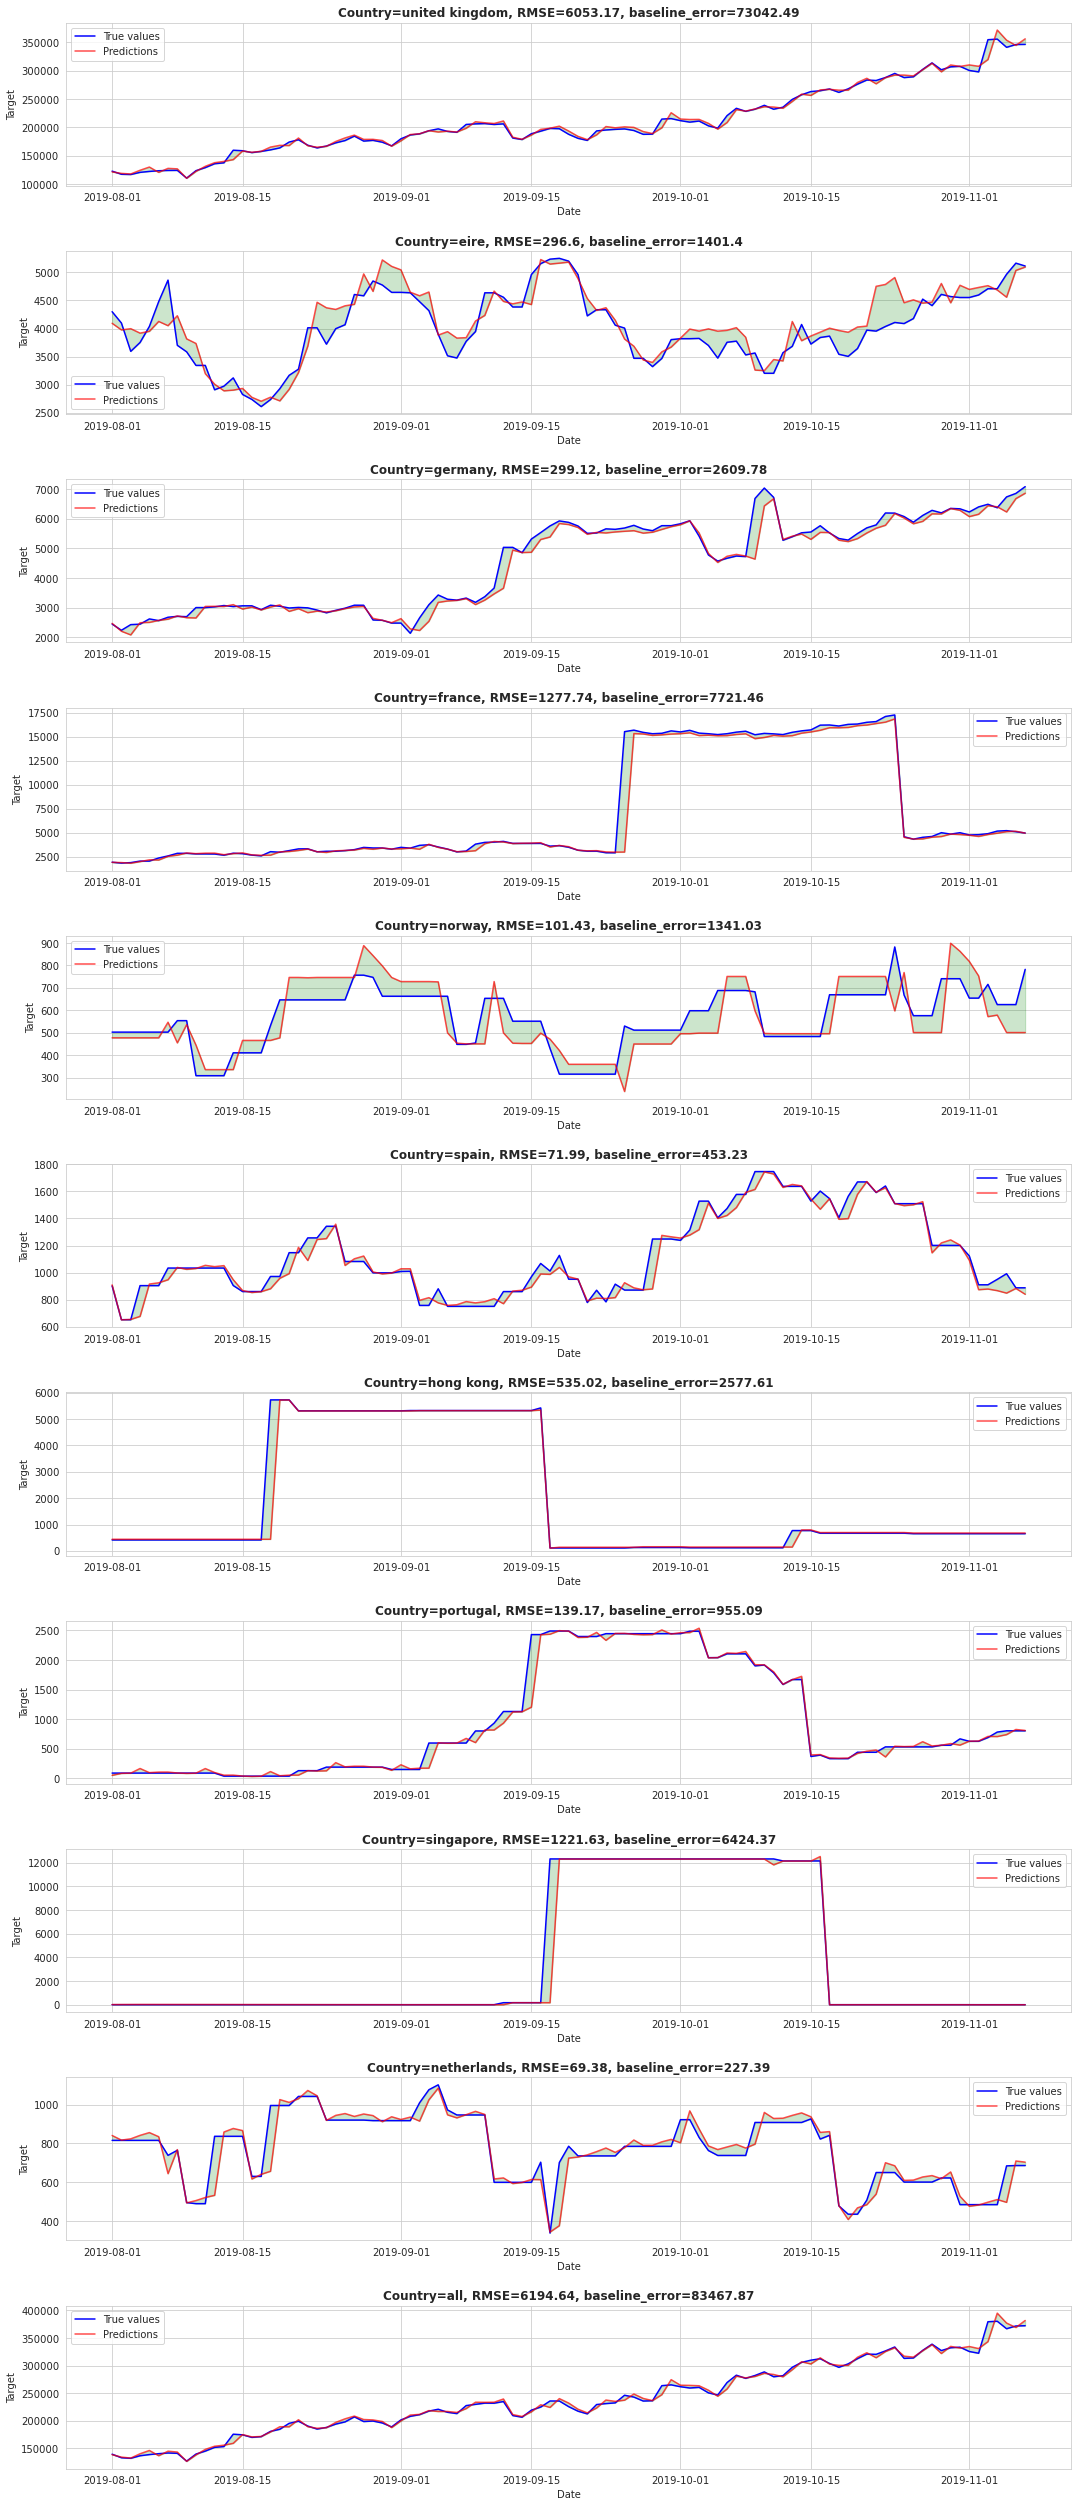

In [39]:
fig, ax = plt.subplots(nrows=11, ncols=1, figsize=(18, 45))
ax = ax.flatten()
    
for idx, country in enumerate(COUNTRIES):
    results_name = [i for i in os.listdir(os.path.join(MODEL_PATH, country)) 
                    if i.startswith('TEST__')][0].split('__')[1]
    
    results = dill.load(open(os.path.join(params['path']['train_results'], country, results_name), 'rb'))
    y_test = results['y_test']
    preds = results['test_preds']
    rmse_error = results['test_error']
    baseline_error = results['base_test_error']
    
    ax[idx].plot(y_test, label='True values', color='blue')
    ax[idx].plot(pd.Series(preds, index=y_test.index), label='Predictions', color='red', alpha=0.7)
    ax[idx].set_title(f'Country={country}, RMSE={round(rmse_error,2)}, baseline_error={round(baseline_error,2)}',
                      fontweight='bold')
    ax[idx].set_xlabel('Date')
    ax[idx].set_ylabel('Target')
    ax[idx].fill_between(x=pd.date_range(y_test.index[0], y_test.index[-1]),
                         y1=np.array(preds),
                         y2=np.array(y_test.values, dtype=np.float64),
                         color='green',
                         alpha=0.2)
    ax[idx].legend()
        
plt.subplots_adjust(hspace=0.4)

The results show that the error on the test data has decreased. Thus, a pipeline was created that creates its own features for each country and selects models that show the best results.